In [8]:
import pandas as pd
from collections import defaultdict
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from collections import namedtuple


We first load all the data:

1. get all the recall reports (note: just working with 100x now)

2. get the samples each gene is present in both methods


In [12]:
# get all reports
path_to_recall_reports = "../cluster/analysis/recall/reports"
all_100x_with_denovo_recall_reports = list(Path(path_to_recall_reports).glob("*/100x/*with_denovo*/*.tsv"))
all_100x_no_denovo_recall_reports = list(Path(path_to_recall_reports).glob("*/100x/*no_denovo*/*.tsv"))

def get_genes_present_in_two_or_more_samples(pandora_matrix_filepath):
    genes_present_in_two_or_more_samples = set()
    with open(pandora_matrix_filepath) as fin:
        for index, line in enumerate(fin):
            if index == 0:
                continue
            line_split = line.strip().split()
            gene = line_split[0]
            presence_list = [int(x) for x in line_split[1:]]
            is_present_in_two_or_more_samples = sum(presence_list) >= 2
            if is_present_in_two_or_more_samples:
                genes_present_in_two_or_more_samples.add(gene)
    return genes_present_in_two_or_more_samples
            
    
genes_present_in_two_or_more_samples_100x_no_denovo = get_genes_present_in_two_or_more_samples("../cluster/data/hps/nobackup/research/zi/projects/pandora_paper/analysis/100x/filter/compare_no_denovo/pandora_multisample.matrix")
genes_present_in_two_or_more_samples_100x_with_denovo = get_genes_present_in_two_or_more_samples("../cluster/data/hps/nobackup/research/zi/projects/pandora_paper/analysis/100x/filter/compare_with_denovo/pandora_multisample.matrix")
genes_present_in_both_methods_and_are_also_in_two_or_more_samples = genes_present_in_two_or_more_samples_100x_no_denovo.intersection(genes_present_in_two_or_more_samples_100x_with_denovo)

print(f"nb of genes_present_in_two_or_more_samples_100x_no_denovo: {len(genes_present_in_two_or_more_samples_100x_no_denovo)}")
print(f"nb of genes_present_in_two_or_more_samples_100x_with_denovo: {len(genes_present_in_two_or_more_samples_100x_with_denovo)}")
print(f"nb of genes_present_in_both_methods_and_are_also_in_two_or_more_samples: {len(genes_present_in_both_methods_and_are_also_in_two_or_more_samples)}")


nb of genes_present_in_two_or_more_samples_100x_no_denovo: 7144
nb of genes_present_in_two_or_more_samples_100x_with_denovo: 7134
nb of genes_present_in_both_methods_and_are_also_in_two_or_more_samples: 7073


We get the classification of the mapping of each truth probe to each gene 


In [15]:
# declare functions to transform classifications to scores
def get_gene_classification_df(report_file):
    recall_report = pd.read_csv(report_file, sep="\t", dtype={"ref_probe_header": str, "classification": str}, keep_default_na=False)
    recall_report["gene"] = recall_report["ref_probe_header"].apply(lambda line: line.split(";")[0].split("=")[-1])
    gene_classification = pd.DataFrame(data=recall_report, columns=["gene", "classification"])

    return gene_classification

def get_gene_classification_df_for_several_files(report_files):
    dfs_from_report_files = [get_gene_classification_df(report_file) for report_file in report_files]
    return pd.concat(dfs_from_report_files)

gene_classification_df_100x_with_denovo = get_gene_classification_df_for_several_files(all_100x_with_denovo_recall_reports)
gene_classification_df_100x_no_denovo = get_gene_classification_df_for_several_files(all_100x_no_denovo_recall_reports)




We define the score of a gene with respect to the mappings of truth probes to this gene.

Let $m$ be a mapping. If a truth probe maps correctly to a gene (i.e. $m$ = primary_correct, $m$ = secondary_correct, $m$ =supplementary_correct), then $score(m) = 1$.
Otherwise, $score(m) = 0$.

Let $g$ be a gene and $M(g)$ be all mappings of truth probes to $g$. Then $score(g) = \sum_{m \in M(g)} score(m)$  


We get $score(g)$ for each gene $g$ without denovo and with denovo.

 

In [16]:
# get the scores 
def get_score(classification):
    if classification in ["unmapped", "partially_mapped", "primary_incorrect", "secondary_incorrect", "supplementary_incorrect"]:
        return -1
    elif classification in ["primary_correct", "secondary_correct", "supplementary_correct"]:
        return 1
    else:
        raise ValueError(f"Unknown classification: {classification}")

def get_gene_to_score(gene_classification):
    gene_to_score = defaultdict(int)
    for index, line in gene_classification.iterrows():
        gene = line["gene"]
        classification = line["classification"]
        score = get_score(classification)
        gene_to_score[gene]+=score
    return gene_to_score

gene_to_score_100x_with_denovo = get_gene_to_score(gene_classification_df_100x_with_denovo)
gene_to_score_100x_no_denovo = get_gene_to_score(gene_classification_df_100x_no_denovo)


In order to take into account genes present in only one method, we add absent genes with score being 0.


In [17]:
def add_absent_genes_to_gene_to_score(gene_to_score, gene_list):
    for gene in gene_list:
        if gene not in gene_to_score:
            gene_to_score[gene] = 0
add_absent_genes_to_gene_to_score(gene_to_score_100x_with_denovo, gene_to_score_100x_no_denovo.keys())
add_absent_genes_to_gene_to_score(gene_to_score_100x_no_denovo, gene_to_score_100x_with_denovo.keys())


Now we do raw score and log score plotting (note that log score plotting we lose some negative scores)


In [18]:
# get a list of scores to be given to scatter plot
genes_with_denovo = gene_to_score_100x_with_denovo.keys()
genes_no_denovo = gene_to_score_100x_no_denovo.keys()
assert genes_with_denovo == genes_no_denovo

def get_scores_as_array_in_order(all_genes, genes_to_include):
    order_of_genes_to_process = [gene for gene in all_genes if gene in genes_to_include]
    
    scores_for_no_denovo_as_array_in_order = [gene_to_score_100x_no_denovo[gene] for gene in order_of_genes_to_process]
    scores_for_denovo_as_array_in_order = [gene_to_score_100x_with_denovo[gene] for gene in order_of_genes_to_process]
    
    return scores_for_no_denovo_as_array_in_order, scores_for_denovo_as_array_in_order

scores_for_no_denovo_as_array_in_order_all_genes, scores_for_denovo_as_array_in_order_all_genes = get_scores_as_array_in_order(genes_with_denovo, genes_with_denovo)
scores_for_no_denovo_as_array_in_order_restricted_genes, scores_for_denovo_as_array_in_order_restricted_genes = get_scores_as_array_in_order(genes_with_denovo, genes_present_in_both_methods_and_are_also_in_two_or_more_samples)



/home/leandro/.local/share/virtualenvs/pandora1_paper-3gSQbOLv/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  
/home/leandro/.local/share/virtualenvs/pandora1_paper-3gSQbOLv/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log10
  
/home/leandro/.local/share/virtualenvs/pandora1_paper-3gSQbOLv/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log10
  import sys
/home/leandro/.local/share/virtualenvs/pandora1_paper-3gSQbOLv/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/leandro/.local/share/virtualenvs/pandora1_paper-3gSQbOLv/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  
/home/leandro/.local/share/virtualenvs/pandora1_paper-3gSQbOLv/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarn

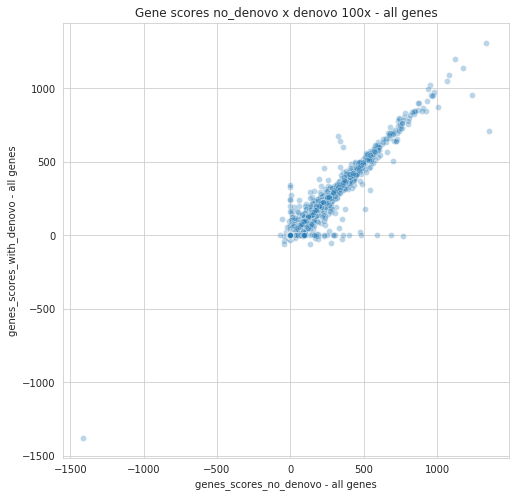

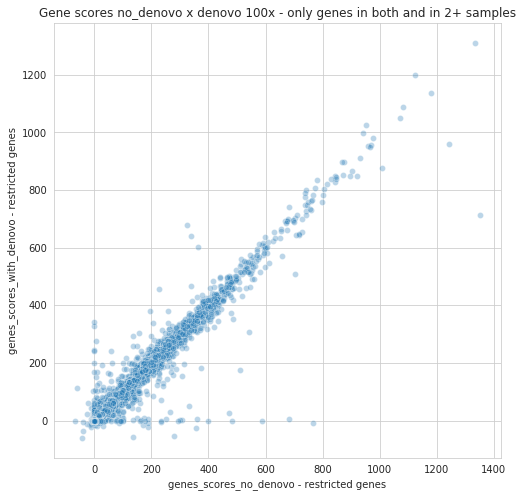

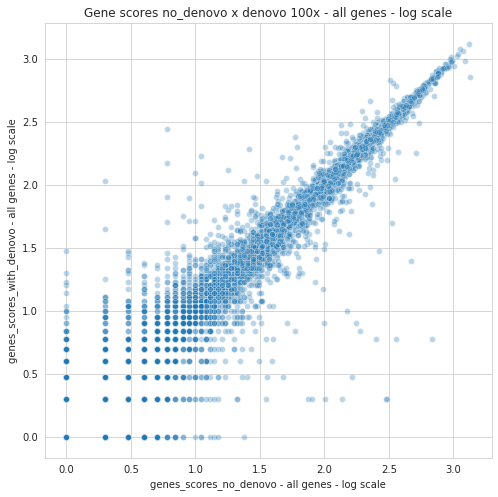

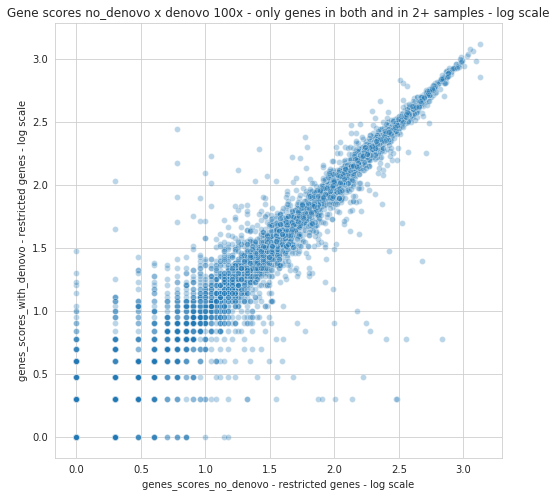

In [22]:
# produce scatterplot with raw scores 
def produce_scatterplot(scores_for_no_denovo, scores_for_denovo, xlabel, ylabel, title, filename, apply_log):
    # TODO : how to deal with the issue of 0 or negative valued scores?
    sns.set_style("whitegrid")
    fig, ax = plt.subplots(figsize=(8,8))
    
    sns.scatterplot(x=scores_for_no_denovo if not apply_log else np.log10(scores_for_no_denovo),
                    y=scores_for_denovo  if not apply_log else np.log10(scores_for_denovo),
                    alpha=0.3, ax=ax)
    
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    fig.savefig(filename)

produce_scatterplot(scores_for_no_denovo=scores_for_no_denovo_as_array_in_order_all_genes,
                    scores_for_denovo=scores_for_denovo_as_array_in_order_all_genes,
                    xlabel="genes_scores_no_denovo - all genes",
                    ylabel="genes_scores_with_denovo - all genes",
                    title="Gene scores no_denovo x denovo 100x - all genes",
                    filename="genes_scores_100x.all_genes.pdf",
                    apply_log=False)

produce_scatterplot(scores_for_no_denovo=scores_for_no_denovo_as_array_in_order_restricted_genes,
                    scores_for_denovo=scores_for_denovo_as_array_in_order_restricted_genes,
                    xlabel="genes_scores_no_denovo - restricted genes",
                    ylabel="genes_scores_with_denovo - restricted genes",
                    title="Gene scores no_denovo x denovo 100x - only genes in both and in 2+ samples",
                    filename="genes_scores_100x.restricted_genes.pdf",
                    apply_log=False)


produce_scatterplot(scores_for_no_denovo=scores_for_no_denovo_as_array_in_order_all_genes,
                    scores_for_denovo=scores_for_denovo_as_array_in_order_all_genes,
                    xlabel="genes_scores_no_denovo - all genes - log scale",
                    ylabel="genes_scores_with_denovo - all genes - log scale",
                    title="Gene scores no_denovo x denovo 100x - all genes - log scale",
                    filename="genes_scores_100x.all_genes_log_scale.pdf",
                    apply_log=True)

produce_scatterplot(scores_for_no_denovo=scores_for_no_denovo_as_array_in_order_restricted_genes,
                    scores_for_denovo=scores_for_denovo_as_array_in_order_restricted_genes,
                    xlabel="genes_scores_no_denovo - restricted genes - log scale",
                    ylabel="genes_scores_with_denovo - restricted genes - log scale",
                    title="Gene scores no_denovo x denovo 100x - only genes in both and in 2+ samples - log scale",
                    filename="genes_scores_100x.restricted_genes_log_scale.pdf",
                    apply_log=True)


In [3]:
# get genes that no_denovo does well and denovo does bad
Gene_scoreWithDeNovo_scoreNoDeNovo = namedtuple("Gene_scoreWithDeNovo_scoreNoDeNovo", "gene scoreWithDeNovo scoreWithNoDenovo delta")
genes_to_investigate = []
for index, gene in enumerate(order_of_genes_to_process):
    no_denovo_does_well_in_this_gene = scores_for_no_denovo_in_log10[index] >= 1.5
    denovo_does_badly_in_this_gene = scores_for_denovo_in_log10[index] <= 1.0
    denovo_score = scores_for_denovo[index]
    no_denovo_score = scores_for_no_denovo[index]
    delta = no_denovo_score - denovo_score
    if no_denovo_does_well_in_this_gene and denovo_does_badly_in_this_gene:
        genes_to_investigate.append(Gene_scoreWithDeNovo_scoreNoDeNovo(gene=gene, scoreWithDeNovo=denovo_score, scoreWithNoDenovo=no_denovo_score, delta=delta))
        
genes_to_investigate = sorted(genes_to_investigate, key= lambda x : x.delta, reverse=True)

output_path = Path("genes_that_nodenovo_does_well_and_denovo_does_bad.txt")
output_path.write_text("\n".join([str(_) for _ in genes_to_investigate]))

genes_to_investigate


NameError: name 'order_of_genes_to_process' is not defined